# Fine Tuning YOLO on a Custom Dataset
This notebook creates a custom dataset of randomly sized and colored circles and triangles along with an annotation file formatted for YOLO. It then uses that data to perform fine tuning on one of the pre-trained models and displays the results.

First let's import all the libraries we'll need for the notebook.

In [1]:
import cv2
import numpy as np
import os
import shutil 
from IPython.display import Image, display, Code
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from ultralytics import YOLO
import supervision as sv
%matplotlib inline

## Create the Dataset

In [2]:
# Specify a root location for the dataset
DATA_DIR = "./datasets"

# Specify the hight and width of the images in the dataset (640 is the default YOLO size)
(IMG_WIDTH, IMG_HEIGHT) = (640, 640)

In [3]:
def delete_dirs(dirs=[]):
    """Deletes a list of directories

    Args:
        dirs (list, optional): The directories to delete. Defaults to [].
    """

    for dir in dirs:
        if os.path.exists(dir):
            shutil.rmtree(dir) 

# Delete folders generated during previous training cycles
delete_dirs(['runs/detect', f'{DATA_DIR}/test', f'{DATA_DIR}/train', f'{DATA_DIR}/val'])

In [4]:
def get_yolo_annotations(x1, y1, x2, y2, image_width, image_height):
    """Convert bounding box annotations to YOLO annotations that are resilient to image resizing.

    Args:
        x1 (int): The pixel coordinate for the left hand side of the bounding box
        y1 (int): The pixel coordinate for the top of the bounding box
        x2 (int): The pixel coordinate for the right hand side of the bounding box
        y2 (int): The pixel coordinate for the bottom of the bounding box
        image_width (int): The width of the image
        image_height (int): The height of the image

    Returns:
        center_x (float): The distance of the bounding box's center from the left side of the image. Expressed in the range of 0.0 to 1.0.
        center_y (float): The distance of the bounding box's center from the top of the image. Expressed in the range of 0.0 to 1.0.
        width (float):    The percentage of the image's width that the bounding box occupies. Expressed in the range of 0.0 to 1.0.
        height (float):   The percentage of the image's height that the bounding box occupies. Expressed in the range of 0.0 to 1.0.
    """

    center_x = (x2+x1)/2/image_width
    center_y = (y2+y1)/2/image_height
    width    = (x2-x1)/image_width
    height   = (y2-y1)/image_height
    
    return center_x, center_y, width, height

In [5]:
def write_yolo_annotations(x1, y1, x2, y2, image_width, image_height, class_id, label_file):
    """Convert the bounding box annotations to YOLO format and write to a file.

    Args:
        x1 (int): The pixel coordinate for the left hand side of the bounding box
        y1 (int): The pixel coordinate for the top of the bounding box
        x2 (int): The pixel coordinate for the right hand side of the bounding box
        y2 (int): The pixel coordinate for the bottom of the bounding box
        image_width (int): The width of the image
        image_height (int): The height of the image
        class_id (int): A unique integer associated with the class
        label_file (string): The file location to write the annotations
    """
    
    # Get YOLO annotations
    center_x, center_y, width, height = get_yolo_annotations(x1, y1, x2, y2, image_width, image_height)

    # Make sure values are reasonable
    if center_x > 0 and center_y > 0 and width > 0 and height > 0 and \
       center_x < 1 and center_y < 1 and width < 1 and height < 1:
        
        # Write the annotations
        f = open(label_file, 'a')
        f.write('{} {} {} {} {}\n'.format(class_id, center_x, center_y, width, height))
        f.close()
    else:
        print(f"At least a portion of the class is outside the image boundary ({center_x}, {center_y}, {width}, {height})")

In [6]:
def draw_random_circle(img):
    """Draws a randomly sized and colored circle on an image

    Args:
        img (array): The image to modify

    Returns:
        center_x (int): The x coordinate for the center of the circle
        center_y (int): The y coordinate for the center of the circle
        radius (int): The radius of the circle
    """
    
    radius   = np.random.randint(10, 100)
    center_x = np.random.randint(radius, IMG_WIDTH-radius)
    center_y = np.random.randint(radius, IMG_HEIGHT-radius)
    color    = (np.random.randint(0, 255), np.random.randint(0, 255), np.random.randint(0, 255))
    
    cv2.circle(img, (center_x, center_y), radius, color, -1)

    return center_x, center_y, radius

In [7]:
def draw_random_triangle(img):
    """Draws a randomly sized and colored triangle on an image

    Args:
        img (array): The image to modify

    Returns:
        lhs (int): The x coordinate for the center of the circle
        rhs (int): The y coordinate for the center of the circle
        top (int): The radius of the circle
        bottom (int) :
    """

    # get a random point in the image at least 100 pixels from the border
    pt1 = (np.random.randint(100, IMG_WIDTH-100), np.random.randint(100, IMG_HEIGHT-100))
    # get a second point 50 to 100 pixels from the first point 
    pt2 = (pt1[0]+np.random.randint(50, 100), pt1[1]+np.random.randint(50, 100))
    # get a third point 50 to 100 pixels from the first point
    pt3 = (pt1[0]-np.random.randint(50, 100), pt1[1]+np.random.randint(50, 100))

    triangle = np.array( [pt1, pt2, pt3] )

    color = (np.random.randint(0, 255), np.random.randint(0, 255), np.random.randint(0, 255))
    
    cv2.drawContours(img, [triangle], 0, color, -1)

    x_vals = [x[0] for x in triangle]
    y_vals = [x[1] for x in triangle]

    lhs = np.min(x_vals)
    rhs = np.max(x_vals)
    top = np.min(y_vals)
    bottom = np.max(y_vals)

    return lhs, rhs, top, bottom

In [8]:
CIRCLE_CLASS_ID = 0
TRIANGLE_CLASS_ID = 1

def create_data(dir, num_images):
    """Populates a directory with a dataset

    Args:
        dir (string): The root directory of the dataset
        num_images (ing): The number of images in the dataset
    """
    
    img_dir   = os.path.join(DATA_DIR, dir, "images")
    label_dir = os.path.join(DATA_DIR, dir, "labels")
    os.makedirs(img_dir,   exist_ok=True)
    os.makedirs(label_dir, exist_ok=True)

    for i in range(num_images):
        img = np.random.randint(0, 255, (IMG_HEIGHT, IMG_WIDTH, 3), "uint8")
        img_file   = "{}/{}.jpg".format(img_dir,   i)
        label_file = "{}/{}.txt".format(label_dir, i)

        center_x, center_y, radius = draw_random_circle(img)
        write_yolo_annotations(center_x-radius, center_y-radius, center_x+radius, center_y+radius, IMG_WIDTH, IMG_HEIGHT, CIRCLE_CLASS_ID, label_file)

        x_min, x_max, y_min, y_max = draw_random_triangle(img)
        write_yolo_annotations(x_min, y_min, x_max, y_max, IMG_WIDTH, IMG_HEIGHT, TRIANGLE_CLASS_ID, label_file)

        cv2.imwrite(img_file, img)

Let's use these methods we just created to make our dataset.

In [9]:
create_data("train", 150)
create_data("test" ,  25) 
create_data("val"  ,   9)  

Let's print out one of our validation images and annotations to make sure everything looks good.

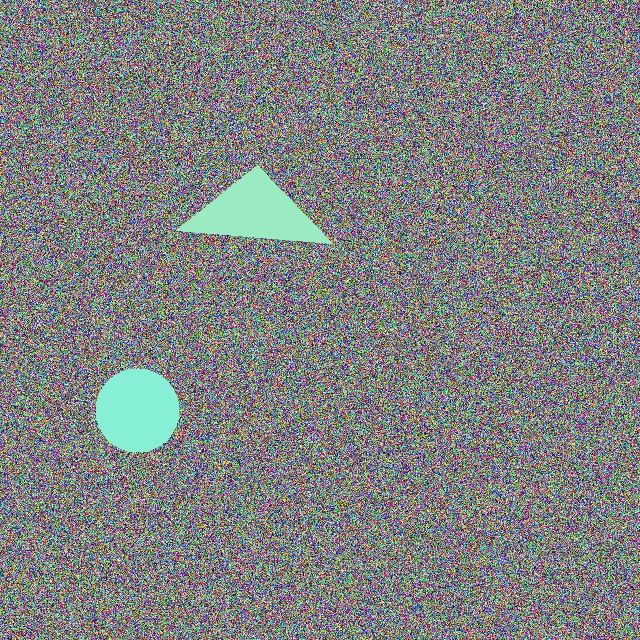

0 0.2140625 0.640625 0.13125 0.13125
1 0.396875 0.31875 0.24375 0.121875

In [10]:
val_images_dir = 'datasets/val/images/'
val_anno_dir   = 'datasets/val/labels/'

images = ["{}{}".format(val_images_dir, image) for image in os.listdir(val_images_dir)]
labels = ["{}{}".format(val_anno_dir,   label) for label in os.listdir(val_anno_dir)]
images.sort()
labels.sort()

# Display the image
display(Image(images[0]))

# Display the annotations
Code(filename=labels[0], language='console')

# Train the Model

In [11]:
def create_config_file(config_file):
    """Creates and writes a YOLO config file necessary for training. 

    Args:
        config_file (str): The filename.'.
    """

    if not os.path.exists(config_file):
        f = open(config_file, "x")
        f.write('''\
# Train and test folders
train: 'train'
val: 'test'

# Number of classes
nc: 2
names: ['circle', 'triangle']''')
        f.close()

config_file = 'object_v11.yaml'
create_config_file(config_file)

In [12]:
# Initialize the YOLO model and print out the supported classes
YOLO_MODEL = 'yolo11n'
model = YOLO('{}.pt'.format(YOLO_MODEL))

print(model.names.values())

dict_values(['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'])


In [13]:
# Start the training
_ = model.train(
    data = config_file,
    imgsz = 640,
    epochs = 50,
    batch = 64,
    #device='cpu',
    name = YOLO_MODEL
)

New https://pypi.org/project/ultralytics/8.3.31 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.28 🚀 Python-3.12.7 torch-2.5.1 CUDA:0 (NVIDIA GeForce GTX 1080 Ti, 11169MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=object_v11.yaml, epochs=50, time=None, patience=100, batch=64, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=yolo11n, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frame

train: Scanning /home/brian/Desktop/code/IK/yolo/datasets/train/labels.cache... 150 images, 0 backgrounds, 0 corrupt: 100%|██████████| 150/150 [00:00<?, ?it/s]
val: Scanning /home/brian/Desktop/code/IK/yolo/datasets/test/labels.cache... 25 images, 0 backgrounds, 0 corrupt: 100%|██████████| 25/25 [00:00<?, ?it/s]


Plotting labels to runs/detect/yolo11n/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/yolo11n
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      4.17G      0.978       3.45      1.122         77        640: 100%|██████████| 3/3 [00:01<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.24it/s]

                   all         25         50    0.00586       0.88       0.14      0.123



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      8.89G      1.014       3.46      1.122         77        640: 100%|██████████| 3/3 [00:01<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.54it/s]

                   all         25         50    0.00573       0.86      0.176      0.159



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      4.12G       0.94       3.39      1.102         75        640: 100%|██████████| 3/3 [00:01<00:00,  1.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.50it/s]

                   all         25         50    0.00628       0.94      0.358      0.324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      8.91G     0.7786      2.999      1.009         59        640: 100%|██████████| 3/3 [00:01<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.41it/s]

                   all         25         50    0.00671          1      0.716      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      8.92G      0.688      2.432     0.9798         75        640: 100%|██████████| 3/3 [00:01<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.26it/s]

                   all         25         50    0.00706          1      0.766      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      8.92G     0.6185      1.846     0.9178         83        640: 100%|██████████| 3/3 [00:01<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.19it/s]

                   all         25         50    0.00707          1      0.841      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      8.91G      0.624      1.419     0.9479         80        640: 100%|██████████| 3/3 [00:01<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.24it/s]

                   all         25         50    0.00673          1      0.936      0.791



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      8.92G     0.6017      1.176     0.9335         59        640: 100%|██████████| 3/3 [00:01<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.19it/s]

                   all         25         50    0.00667          1      0.957      0.835



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      8.91G     0.5654      1.056     0.9062         70        640: 100%|██████████| 3/3 [00:01<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.00it/s]

                   all         25         50    0.00667          1      0.944      0.834



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      8.92G     0.5275     0.9996      0.917         63        640: 100%|██████████| 3/3 [00:01<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.34it/s]

                   all         25         50    0.00668          1      0.923      0.812



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      8.92G     0.5414     0.9592     0.9061         61        640: 100%|██████████| 3/3 [00:01<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.90it/s]

                   all         25         50    0.00667          1      0.908        0.8



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      8.92G     0.4994     0.9201      0.883         73        640: 100%|██████████| 3/3 [00:01<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.18it/s]

                   all         25         50    0.00669       0.98      0.919      0.785



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      8.92G     0.4802     0.8777     0.8717         56        640: 100%|██████████| 3/3 [00:01<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.27it/s]

                   all         25         50          1      0.184      0.915      0.805



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      8.92G     0.5226     0.9121     0.9068         65        640: 100%|██████████| 3/3 [00:01<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.23it/s]

                   all         25         50          1      0.231      0.875      0.775



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      8.92G     0.5045     0.9044     0.8937         66        640: 100%|██████████| 3/3 [00:01<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.49it/s]

                   all         25         50    0.00667          1      0.842      0.755



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      8.92G     0.5164     0.8415     0.8984         63        640: 100%|██████████| 3/3 [00:01<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.45it/s]

                   all         25         50      0.945      0.373      0.828      0.751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      8.92G     0.4951     0.8281     0.8803         74        640: 100%|██████████| 3/3 [00:01<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.42it/s]

                   all         25         50          1      0.284      0.835      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      8.92G     0.5061     0.7923     0.8989         76        640: 100%|██████████| 3/3 [00:01<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.35it/s]

                   all         25         50          1      0.268       0.94      0.863



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      8.92G     0.4921     0.8269     0.8959         61        640: 100%|██████████| 3/3 [00:01<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.41it/s]

                   all         25         50          1       0.56      0.926      0.836



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      8.92G     0.4775     0.8079     0.8792         66        640: 100%|██████████| 3/3 [00:01<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.36it/s]

                   all         25         50          1       0.27      0.897      0.816



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      8.92G     0.4337     0.7514     0.8747         65        640: 100%|██████████| 3/3 [00:01<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.25it/s]

                   all         25         50          1      0.298       0.93      0.856



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      8.92G     0.4852     0.7795     0.8777         61        640: 100%|██████████| 3/3 [00:01<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.14it/s]

                   all         25         50          1      0.302      0.964      0.875



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      8.91G     0.4675     0.7577     0.8688         57        640: 100%|██████████| 3/3 [00:01<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.19it/s]

                   all         25         50      0.984       0.34      0.944      0.862



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      8.92G     0.4412     0.7157     0.8655         67        640: 100%|██████████| 3/3 [00:01<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.15it/s]

                   all         25         50      0.972      0.369      0.955      0.882



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      8.91G     0.4922     0.7635     0.8858         49        640: 100%|██████████| 3/3 [00:01<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.08it/s]

                   all         25         50          1      0.492      0.992      0.912



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      8.92G     0.4672     0.7121     0.8966         66        640: 100%|██████████| 3/3 [00:01<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.13it/s]

                   all         25         50          1      0.537      0.992      0.905



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      8.92G     0.4219     0.6789     0.8482         84        640: 100%|██████████| 3/3 [00:01<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.61it/s]

                   all         25         50          1      0.868      0.992      0.916



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      8.92G     0.4391     0.7066     0.8812         45        640: 100%|██████████| 3/3 [00:01<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.24it/s]

                   all         25         50      0.999      0.922      0.993      0.924



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      8.92G     0.4351     0.6743      0.868         73        640: 100%|██████████| 3/3 [00:01<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.47it/s]

                   all         25         50      0.985      0.949      0.994      0.921



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      8.92G     0.4589      0.691     0.8918         65        640: 100%|██████████| 3/3 [00:01<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.30it/s]

                   all         25         50      0.986      0.974      0.994      0.941



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      8.92G     0.4408      0.652     0.8712         72        640: 100%|██████████| 3/3 [00:01<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.28it/s]

                   all         25         50      0.991      0.982      0.995      0.924



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      8.92G     0.4293     0.6406     0.8693         77        640: 100%|██████████| 3/3 [00:01<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.23it/s]

                   all         25         50      0.988      0.992      0.995      0.937



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      8.92G     0.4026     0.6368     0.8629         52        640: 100%|██████████| 3/3 [00:01<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.48it/s]

                   all         25         50      0.985          1      0.995      0.926



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      8.92G     0.4271     0.6211     0.8594         86        640: 100%|██████████| 3/3 [00:01<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.62it/s]

                   all         25         50      0.982          1      0.995      0.932



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      8.92G     0.4294     0.6394     0.8779         61        640: 100%|██████████| 3/3 [00:01<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.83it/s]

                   all         25         50      0.984      0.978      0.995      0.971



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      8.92G      0.433     0.6378     0.8584         59        640: 100%|██████████| 3/3 [00:01<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.89it/s]

                   all         25         50       0.99      0.997      0.995      0.933



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      8.92G     0.4277     0.6256     0.8628         51        640: 100%|██████████| 3/3 [00:01<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.98it/s]

                   all         25         50      0.992          1      0.995      0.949



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      8.92G     0.4208     0.6281     0.8734         71        640: 100%|██████████| 3/3 [00:01<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.13it/s]

                   all         25         50      0.992          1      0.995      0.939



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      8.91G     0.4365     0.6021     0.8824         66        640: 100%|██████████| 3/3 [00:01<00:00,  2.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.16it/s]

                   all         25         50      0.987          1      0.995      0.948



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      8.92G     0.4218     0.5751     0.8643         93        640: 100%|██████████| 3/3 [00:01<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.20it/s]

                   all         25         50      0.986          1      0.995      0.943


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      8.85G     0.2886     0.6006     0.8098         44        640: 100%|██████████| 3/3 [00:02<00:00,  1.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.85it/s]

                   all         25         50      0.987      0.998      0.995      0.968



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      8.85G     0.2949     0.6071     0.8242         44        640: 100%|██████████| 3/3 [00:01<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.42it/s]

                   all         25         50      0.985          1      0.995      0.968



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      8.85G     0.2748     0.5882     0.8104         42        640: 100%|██████████| 3/3 [00:01<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.40it/s]

                   all         25         50      0.987          1      0.995      0.964



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      8.85G     0.2944     0.5642     0.8166         44        640: 100%|██████████| 3/3 [00:01<00:00,  2.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.53it/s]

                   all         25         50      0.983          1      0.995      0.979



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      8.85G     0.2665     0.5625     0.8107         43        640: 100%|██████████| 3/3 [00:01<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.61it/s]

                   all         25         50       0.99          1      0.995      0.973



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      8.85G     0.2666     0.5471     0.8195         41        640: 100%|██████████| 3/3 [00:01<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.52it/s]

                   all         25         50      0.995          1      0.995      0.963



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      8.85G     0.2665     0.5209     0.7927         42        640: 100%|██████████| 3/3 [00:01<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.63it/s]

                   all         25         50      0.996          1      0.995      0.972



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      8.85G     0.2548      0.525     0.8044         42        640: 100%|██████████| 3/3 [00:01<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.60it/s]

                   all         25         50      0.996          1      0.995       0.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      8.85G     0.2511     0.5092     0.7899         43        640: 100%|██████████| 3/3 [00:01<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.42it/s]

                   all         25         50      0.996          1      0.995      0.976



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      8.85G      0.239     0.5086     0.7962         44        640: 100%|██████████| 3/3 [00:01<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.66it/s]

                   all         25         50      0.995          1      0.995      0.982



50 epochs completed in 0.031 hours.
Optimizer stripped from runs/detect/yolo11n/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/yolo11n/weights/best.pt, 5.5MB

Validating runs/detect/yolo11n/weights/best.pt...
Ultralytics 8.3.28 🚀 Python-3.12.7 torch-2.5.1 CUDA:0 (NVIDIA GeForce GTX 1080 Ti, 11169MiB)
YOLO11n summary (fused): 238 layers, 2,582,542 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.05it/s]


                   all         25         50      0.995          1      0.995      0.982
                circle         25         25      0.997          1      0.995      0.974
              triangle         25         25      0.993          1      0.995       0.99
Speed: 0.2ms preprocess, 2.1ms inference, 0.0ms loss, 0.6ms postprocess per image
Results saved to runs/detect/yolo11n


In [14]:
# Display the classes the model supports now
print(model.names)

{0: 'circle', 1: 'triangle'}


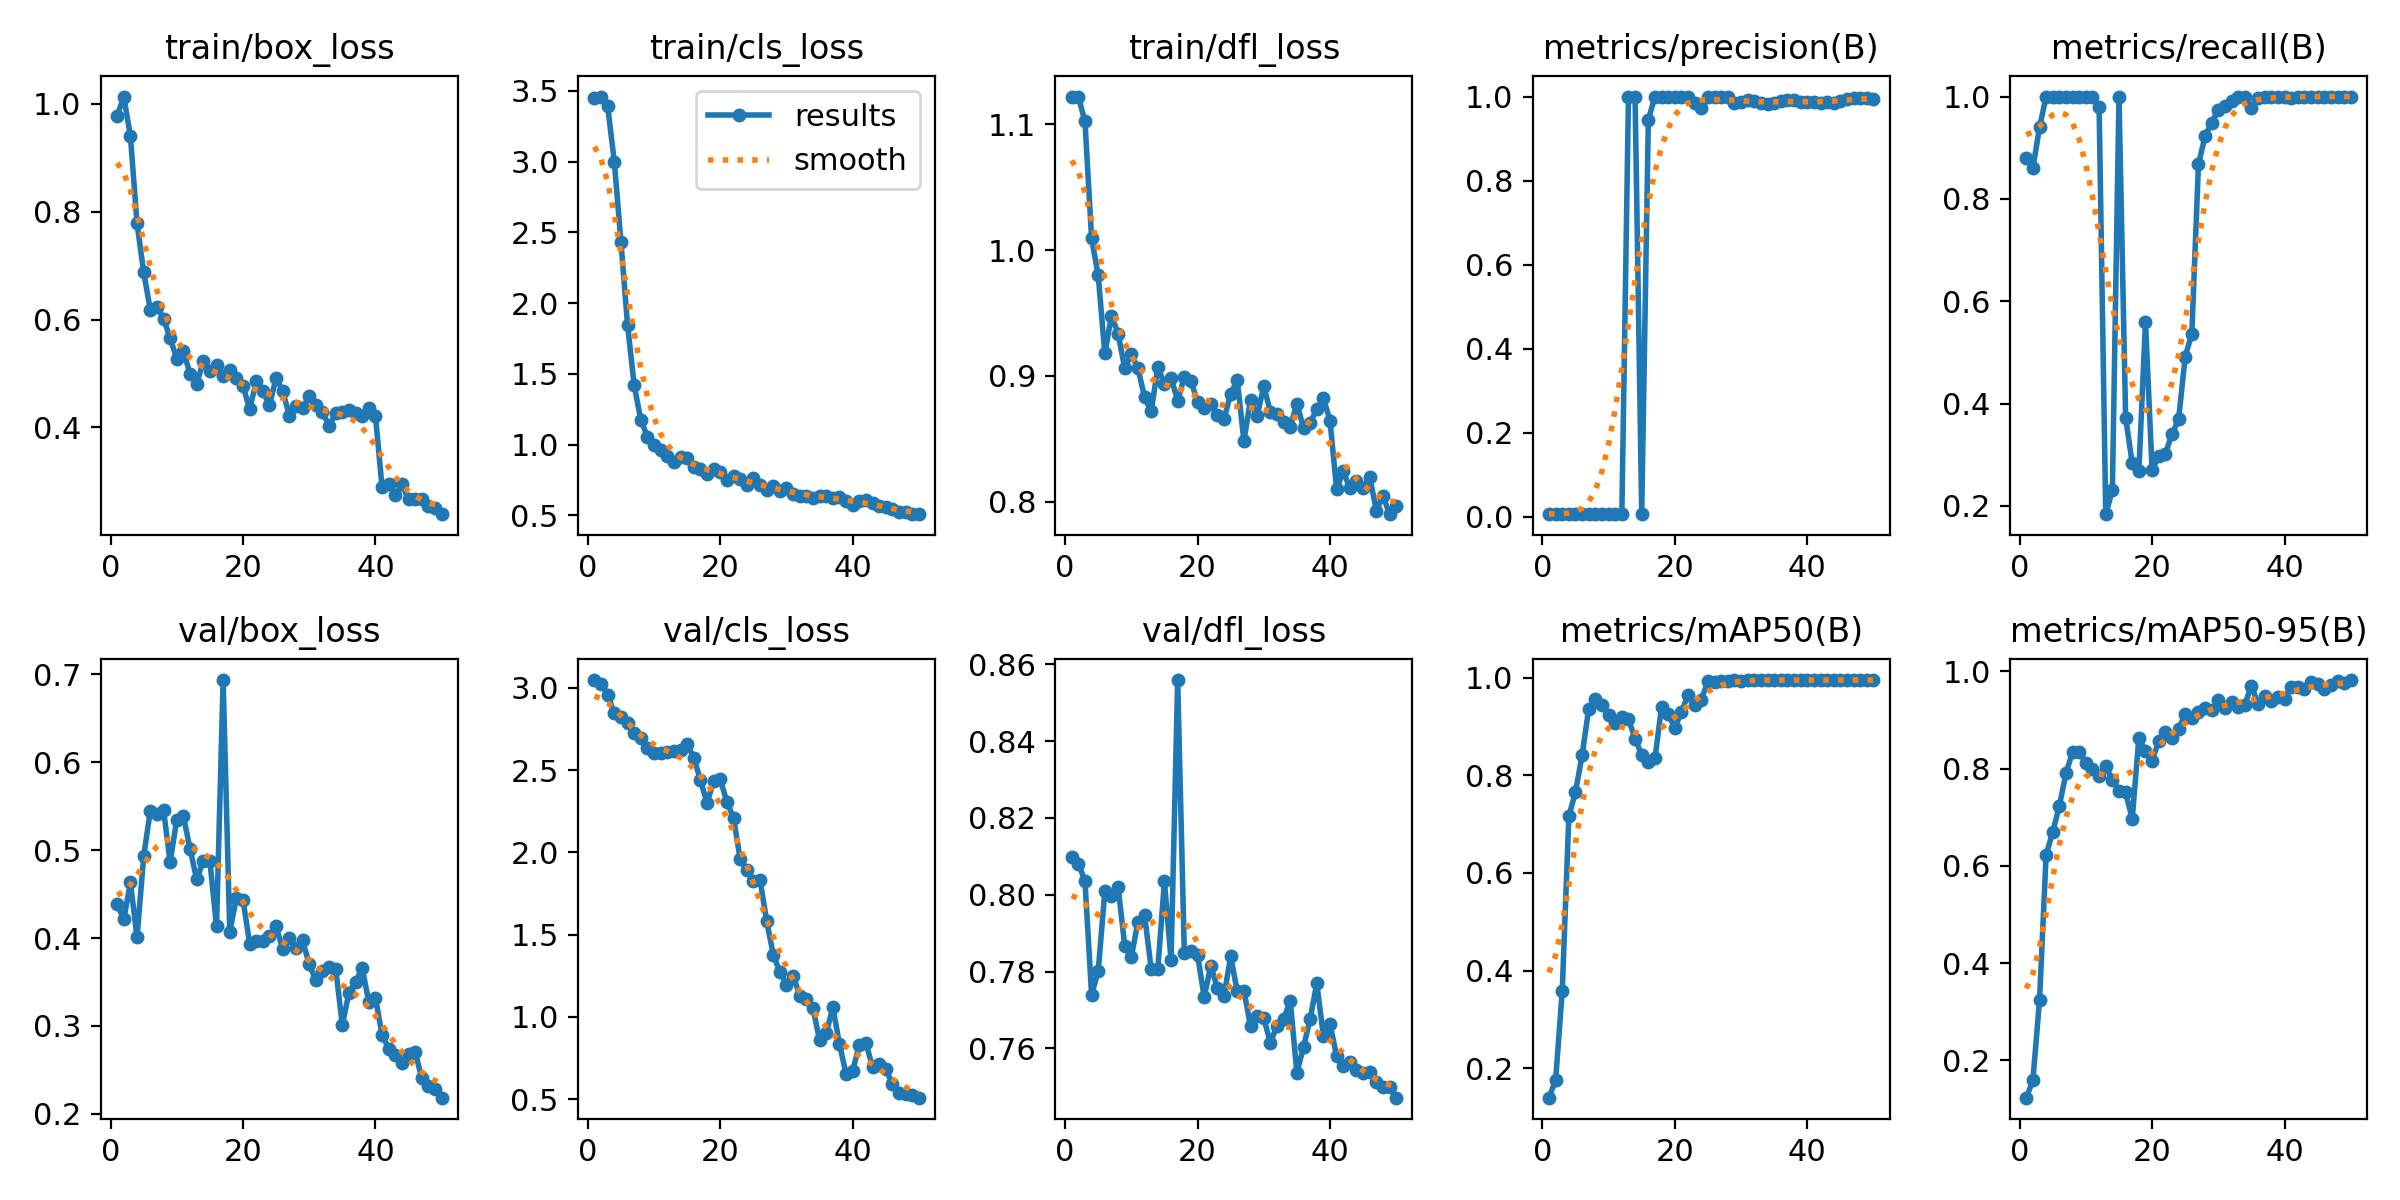

In [15]:
# Display the training characteristics
display(Image(f'runs/detect/{YOLO_MODEL}/results.png'))

## Run YOLO

Let's annotate some of the model's output to see how it does.

In [16]:
# Load the best model
best_yolo_model = f'runs/detect/{YOLO_MODEL}/weights/best.pt'
model = YOLO(best_yolo_model)

# Load the paths to the validation images
val_images_dir = f'{DATA_DIR}/val/images/'
test_images = ["{}{}".format(val_images_dir, image) for image in os.listdir(val_images_dir)]
batch_size = 64

# Create annotators for bounding box and labels
box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator(text_position=sv.Position.TOP_LEFT)

images = []

for i in range(0, len(test_images), batch_size):
    results = model.predict(test_images[i:i + batch_size])
    for result in results:
        detections = sv.Detections.from_ultralytics(result)
        img = cv2.imread(result.path, cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Annotate
        annotated_image = box_annotator.annotate(scene=img, detections=detections)
        annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

        images.append(annotated_image)


0: 640x640 1 circle, 1 triangle, 3.5ms
1: 640x640 1 circle, 1 triangle, 3.5ms
2: 640x640 1 circle, 1 triangle, 3.5ms
3: 640x640 1 circle, 1 triangle, 3.5ms
4: 640x640 1 circle, 1 triangle, 3.5ms
5: 640x640 1 circle, 1 triangle, 3.5ms
6: 640x640 1 circle, 1 triangle, 3.5ms
7: 640x640 1 circle, 1 triangle, 3.5ms
8: 640x640 1 circle, 1 triangle, 3.5ms
Speed: 1.6ms preprocess, 3.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


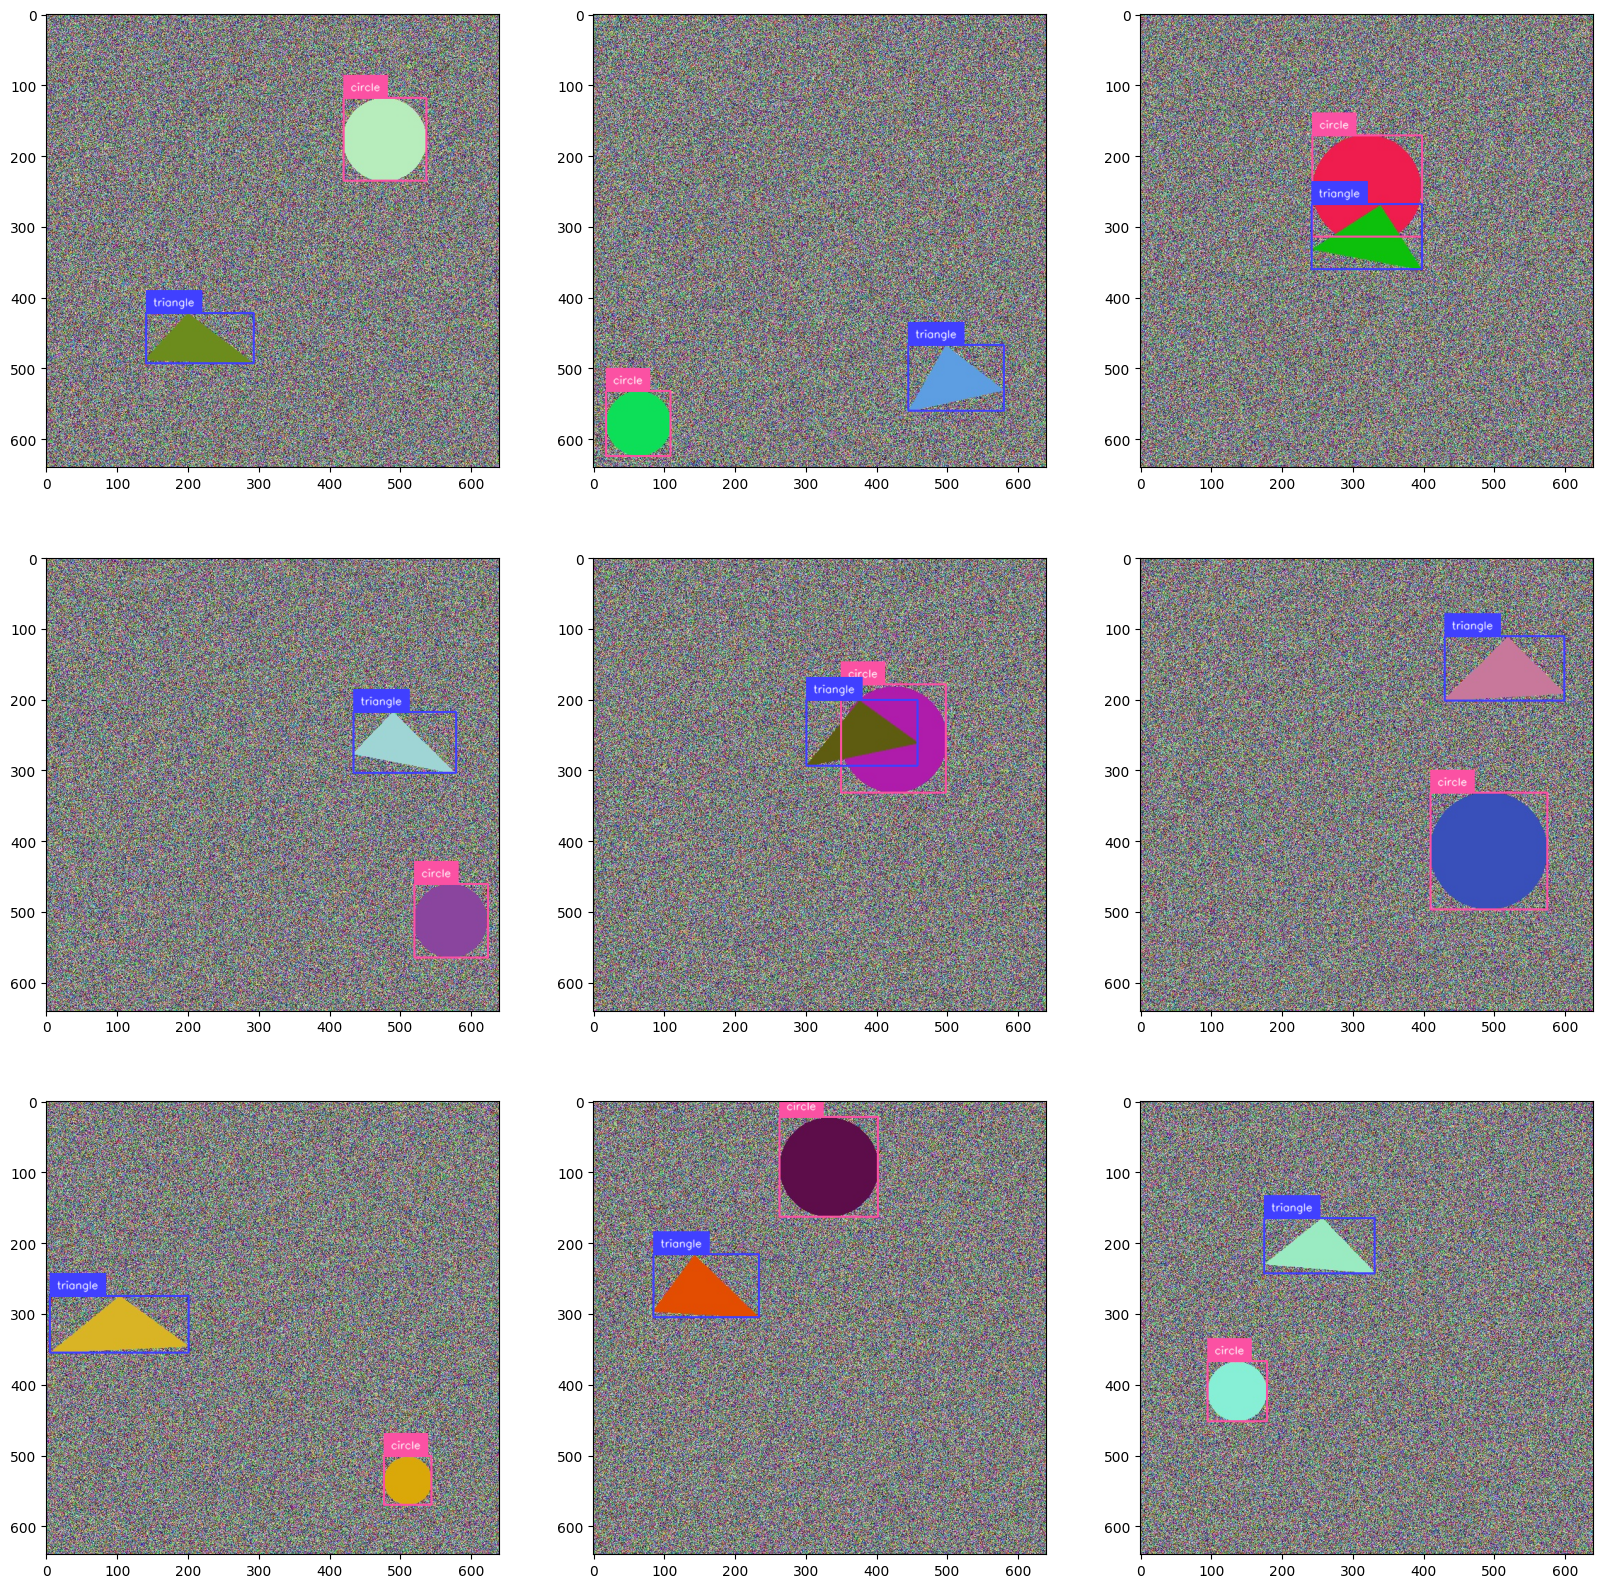

In [17]:
plt.figure(figsize=(20,20)) # specify the individual image size

for i in range(9):
    plt.subplot(3,3,i+1)    
    plt.imshow(images[i])

plt.show()